Test clustering network output curves from simulations with random parameter sets and output weights

In [247]:
import os
import sys
import numpy as np
import pandas as pd
import eqtk

#For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import plotnine as p9 #easier for some things

#For clustering
from fastdist import fastdist
import scipy.cluster.hierarchy as hcluster
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from scipy.spatial.distance import pdist



In [2]:
pwd = os.path.abspath('../..')
sys.path.append(os.path.join(pwd, 'code/')) 
import utilities
from utilities import *

In [3]:
#Set plotting defaults
sn.set_style('ticks')
mpl.rcParams.update({'text.color': 'black', 'axes.labelcolor': 'black', 
                     'xtick.color': 'black', 'ytick.color': 'black', 'figure.dpi':100, 'savefig.dpi':300,
                     'savefig.bbox': 'tight', 'savefig.transparent': True, 'mathtext.default':'regular'})
sn.set_context('notebook')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
def scale_axis(mat, axis=0):
    mat_mn = np.expand_dims(mat.mean(axis = axis), axis)
    mat_sd = np.expand_dims(mat.std(axis = 0), axis)
    mat_scaled = (mat - mat_mn)/mat_sd
    return mat_scaled

## Test clustering
First try clustering outputs in 1 universe and across universes with 1 output weight vector

In [10]:
out_test_scaled = scale_axis(out_test[:,0,:])

In [49]:
#Using scipy for now. Later for efficiency, can write jitted distance function. Note, underwhelming performance with fastdist package
def hc_mat(mat, scale=False, axis=0, dist_metric='euclidean',
           link_method='centroid', cluster_criterion='distance', 
           threshold=3):
    """
    """
    if scale:
        mat = scale_axis(mat, axis=axis)
    
    mat_dist = pdist(mat.T, metric=dist_metric)
    mat_link = hcluster.linkage(mat_dist, method=link_method)
    mat_cluters = hcluster.fcluster(mat_link, threshold, criterion=cluster_criterion)
    return mat_dist, mat_link, mat_cluters

In [237]:
def plot_outcurves_clustered(outmat, cluster_labels, average=True, shaded='max-min', 
                             percentiles=(0.05, 0.95), sample_n = None, xticks = [0,4,9],
                             xticklabels = [-3,0,3], add_legend = False, plot_width=7, plot_height=5):
    """
    """
    clusters = np.unique(cluster_labels)
    n_clusters = len(clusters)
    # n_outweights = outmat.shape[2]
    n_titration = outmat.shape[0]
    
    xticklabels = [f'$10^{{{i}}}$' for i in xticklabels]
    fig, axes = plt.subplots(1, n_clusters, figsize=(n_clusters*plot_width, plot_height), squeeze=False, constrained_layout=True)
    for i, clust in enumerate(clusters):
        cluster_ind = np.nonzero(cluster_labels == clust)[0]
        outmat_clust = outmat[:,cluster_ind]
        clust_percent = np.round(outmat_clust.shape[1]/outmat.shape[1] * 100, 2)
        if average:
            cluster_mean = outmat_clust.mean(axis=1)
            
            if shaded == 'max-min':
                cluster_lb = outmat_clust.min(axis=1)
                cluster_ub = outmat_clust.max(axis=1)
                label = 'max-min'
            elif shaded == 'percentile':
                cluster_lb = np.percentile(outmat_clust, percentiles[0], axis = 1)
                cluster_ub = np.percentile(outmat_clust, percentiles[1], axis = 1)
                label = f'{percentiles[0]}-{percentiles[1]} percentile'
                
            axes[(0,i)].plot(np.arange(n_titration), cluster_mean, label='average')
            axes[(0,i)].fill_between(np.arange(n_titration), cluster_lb, cluster_ub, alpha=0.2, label=label)
        
        else: #plot individual curves
            if sample_n is not None and sample_n < outmat_clust.shape[1]:
                rand_ind = np.random.choice(np.arange(outmat_clust.shape[1]), size=sample_n, replace=False)
                outmat_clust = outmat_clust[:,rand_ind]
            for j in range(outmat_clust.shape[1]):
                axes[(0,i)].plot(np.arange(n_titration), outmat_clust[:,j])
        
        #Format axes
        axes[(0,i)].set(ylabel='out',xticks = xticks, xticklabels = xticklabels,
                        title=f'cluster: {clust}, {clust_percent}%')
        if add_legend:
                axes[(0,i)].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    return fig, axes
        
    

Perform hierarchical clustering on each parameter universe seperately
(it will take to long to compute pairwise distances on all 1000 universes X 1000 output weights) at once

Save intermediate distance and linkage array in case we decide to change methods or thresholds later. 

In [105]:
indir = '../../data/20220617_1input_randomParams_highRes/'
outdir = '../../data/20220617_1input_randomParams_highRes/hierarchical_clustering/'
if not os.path.exists(outdir):
    os.mkdir(outdir)


In [243]:
# Loop through different size networks then through all universes within each network
dist_all = [0]*4
link_all = [0]*4
clusters_all = [0]*4

for m in range(3,7):
    outmat = np.load(f'{indir}output_{m}M_LHSsample_1000k.npy')
    n_univ = outmat.shape[1]
    dist_combined = [0]*n_univ
    link_combined = [0]*n_univ
    clusters_combined = [0]*n_univ
    for univ in range(n_univ):
        dist_mat, link_mat, clusters = hc_mat(outmat[:,univ,:], scale=True, axis=0, dist_metric='euclidean',
                                          link_method='centroid', cluster_criterion='distance',
                                          threshold=3)
        dist_combined[univ] = dist_mat
        link_combined[univ] = link_mat
        clusters_combined[univ] = clusters
    
    dist_all[m-3] = np.stack(dist_combined)
    link_all[m-3] = np.stack(link_combined)
    clusters_all[m-3] = np.stack(clusters_combined)
    #save data
    np.save(os.path.join(outdir, f'hc_{m}M_{n_univ}univ_dist.npy'), dist_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_{n_univ}univ_linkage.npy'), link_all[m-3])
    np.save(os.path.join(outdir, f'hc_{m}M_{n_univ}univ_clusters_thresh{3}.npy'), clusters_all[m-3])

    


Are there a greater number of clusters for certain parameter universes? 
Do certain parameter universes generate more distinct clusters? 
For the latter question, calculate the average curve for each cluster (within each universe)
then compute distances between average curves and see which universes have the largest (mean?) distance between
average curves. 

In [245]:
cluster_counts_all = [0] * 4
cluster_basis_all = [0] * 4
for m in range(4):
    clusters_mat = clusters_all[m]
    cluster_counts = np.apply_along_axis(lambda x: len(np.unique(x)), 1, clusters_mat)
    cluster_counts_all[m] = cluster_counts
    
    #Now compute basis curves
    outmat = np.load(os.path.join(indir, f'output_{m+3}M_LHSsample_1000k.npy'))

    n_univ = clusters_all[m].shape[0]
    basis_combined = [0]*n_univ
    for univ in range(n_univ):
        outmat_scaled = scale_axis(outmat[:,univ,:], axis = 0)
        cluster_labels = clusters_mat[univ,:]
        clusters = np.unique(cluster_labels)
        basis = np.zeros((len(clusters), outmat_scaled.shape[0]))
        for i, clust in enumerate(clusters):
            cluster_ind = np.nonzero(cluster_labels == clust)[0]
            outmat_clust = outmat_scaled[:,cluster_ind]
            basis[i,:] = outmat_clust.mean(axis=1)
        basis_combined[univ] = basis
    
    cluster_basis_all[m] = basis_combined

In [252]:
cluster_counts_df = pd.DataFrame(np.vstack(cluster_counts_all).T, columns=[f'M={i}' for i in range(3,7)])
cluster_counts_df['univ'] = cluster_counts_df.index
cluster_counts_df_long = cluster_counts_df.melt(id_vars='univ', var_name='network_size', value_name='n_clusters')

In [272]:
p = (p9.ggplot(cluster_counts_df_long, p9.aes(x='n_clusters'))
 + p9.geom_histogram(binwidth = 3)
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh3.pdf
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Try larger threshold

In [296]:
thresh = 5
clusters_all_5 = [0]*4
n_univ = 1000
for m in range(4):
    clusters_combined = [0]*n_univ
    for univ in range(n_univ):
        clusters_combined[univ] = hcluster.fcluster(link_all[m][univ,:,:], thresh, criterion='distance')
    clusters_all_5[m] = np.stack(clusters_combined)


In [346]:
cluster_counts_all_5 = [0] * 4
cluster_basis_all_5 = [0] * 4
for m in range(4):
    clusters_mat = clusters_all_5[m]
    cluster_counts = np.apply_along_axis(lambda x: len(np.unique(x)), 1, clusters_mat)
    cluster_counts_all_5[m] = cluster_counts
    
    #Now compute basis curves
    outmat = np.load(os.path.join(indir, f'output_{m+3}M_LHSsample_1000k.npy'))

    n_univ = clusters_all_5[m].shape[0]
    basis_combined = [0]*n_univ
    for univ in range(n_univ):
        outmat_scaled = scale_axis(outmat[:,univ,:], axis = 0)
        cluster_labels = clusters_mat[univ,:]
        clusters = np.unique(cluster_labels)
        basis = np.zeros((len(clusters), outmat_scaled.shape[0]))
        for i, clust in enumerate(clusters):
            cluster_ind = np.nonzero(cluster_labels == clust)[0]
            outmat_clust = outmat_scaled[:,cluster_ind]
            basis[i,:] = outmat_clust.mean(axis=1)
        basis_combined[univ] = basis
    
    cluster_basis_all_5[m] = basis_combined

In [299]:
p = (p9.ggplot(cluster_counts_5_df_long, p9.aes(x='n_clusters'))
 + p9.geom_histogram(binwidth = 3)
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh5.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh5.pdf
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Plot clusters for a few example universes. Also plot universes with the largest number of clusters

In [361]:
def plot_outcurves_clustered2(outmat, cluster_labels, shaded='max-min', clusters = None, 
                             percentiles=(0.05, 0.95), sample_n = 10, xticks = [0,4,9],
                             xticklabels = [-3,0,3], add_legend = False, plot_width=7, plot_height=10):
    """
    """
    if clusters is None: #plot all clusters  
        clusters = np.unique(cluster_labels)
    
    n_clusters = len(clusters)    
    # n_outweights = outmat.shape[2]
    n_titration = outmat.shape[0]
    
    xticklabels = [f'$10^{{{i}}}$' for i in xticklabels]
    fig, axes = plt.subplots(2, n_clusters, figsize=(n_clusters*plot_width, plot_height), squeeze=False, constrained_layout=True)
    for i, clust in enumerate(clusters):
        cluster_ind = np.nonzero(cluster_labels == clust)[0]
        outmat_clust = outmat[:,cluster_ind]
        clust_percent = np.round(outmat_clust.shape[1]/outmat.shape[1] * 100, 2)
        
        #Plot cluster average on the top row
        cluster_mean = outmat_clust.mean(axis=1)

        if shaded == 'max-min':
            cluster_lb = outmat_clust.min(axis=1)
            cluster_ub = outmat_clust.max(axis=1)
            label = 'max-min'
        elif shaded == 'percentile':
            cluster_lb = np.percentile(outmat_clust, percentiles[0], axis = 1)
            cluster_ub = np.percentile(outmat_clust, percentiles[1], axis = 1)
            label = f'{percentiles[0]}-{percentiles[1]} percentile'

        axes[(0,i)].plot(np.arange(n_titration), cluster_mean, label='average')
        axes[(0,i)].fill_between(np.arange(n_titration), cluster_lb, cluster_ub, alpha=0.2, label=label)
        
        #plot example curves on the bottom row
        if sample_n is not None and sample_n < outmat_clust.shape[1]:
            rand_ind = np.random.choice(np.arange(outmat_clust.shape[1]), size=sample_n, replace=False)
            outmat_clust = outmat_clust[:,rand_ind]
        for j in range(outmat_clust.shape[1]):
            axes[(1,i)].plot(np.arange(n_titration), outmat_clust[:,j])
        
        #Format axes
        axes[(0,i)].set(ylabel='out',xticks = xticks, xticklabels = xticklabels,
                        title=f'cluster: {clust}, {clust_percent}%')
        axes[(1,i)].set(ylabel='out',xticks = xticks, xticklabels = xticklabels,
                        title=f'example curves:')
        if add_legend:
                axes[(0,i)].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    return fig, axes
        

In [303]:
univ_rand10 = np.random.choice(np.arange(1000), 10, replace=False)

for m in range(4):
    outmat = np.load(f'../../data/20220617_1input_randomParams_highRes/output_{m+3}M_LHSsample_1000k.npy')
    
    clusters = clusters_all[m]
    for univ in univ_rand10:
        outmat_scaled = scale_axis(outmat[:,univ,:])
        
        fig1, axes1 = plot_outcurves_clustered2(outmat_scaled, clusters[univ,:], 
                                               shaded='max-min',
                                               xticks = [0,49,99],
                                               xticklabels = [-3,0,3], add_legend = True)
        fig1.suptitle(f'Universe {univ}')
        fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_univ{univ}_thresh3.pdf')
        plt.close()


In [304]:

for m in range(4):
    outmat = np.load(f'../../data/20220617_1input_randomParams_highRes/output_{m+3}M_LHSsample_1000k.npy')
    
    clusters = clusters_all_5[m]
    for univ in univ_rand10:
        outmat_scaled = scale_axis(outmat[:,univ,:])
        
        fig1, axes1 = plot_outcurves_clustered2(outmat_scaled, clusters[univ,:], 
                                               shaded='max-min',
                                               xticks = [0,49,99],
                                               xticklabels = [-3,0,3], add_legend = True)
        fig1.suptitle(f'Universe {univ}')
        fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_univ{univ}_thresh5.pdf')
        plt.close()


For each universe within each network, compute distance between basis curves. May work as a metric to find more expressive universes. 

In [308]:
basis_dist_all = [0]*4
basis_dist_mean_all = [0]*4
basis_dist_median_all = [0]*4
for m in range(4):
    n_univ = len(cluster_basis_all[m])
    basis_dist_combined = [0]*n_univ
    basis_dist_mean_combined = [0]*n_univ
    basis_dist_median_combined = [0]*n_univ
    for univ in range(n_univ):
        if cluster_basis_all[m][univ].shape[0] == 1:
            basis_dist = [0]
            basis_dist_mean_combined[univ] = 0
            basis_dist_median_combined[univ] = 0
        else:
            basis_dist = pdist(cluster_basis_all[m][univ], metric='euclidean')
            basis_dist_combined[univ] = basis_dist
            basis_dist_mean_combined[univ] = basis_dist.mean()
            basis_dist_median_combined[univ] = np.median(basis_dist)
    basis_dist_all[m] = basis_dist_combined
    basis_dist_mean_all[m] = np.array(basis_dist_mean_combined)
    basis_dist_median_all[m] = np.array(basis_dist_median_combined)

I don't see a ton of variation. Instead of average distance, try computing fano/CV at each x
position across clusters

In [309]:
basis_fano_all = [0]*4
basis_cv_all = [0]*4
for m in range(4):
    n_univ = len(cluster_basis_all[m])
    basis_fano_combined = [0]*n_univ
    basis_cv_combined = [0]*n_univ
    for univ in range(n_univ):
        if cluster_basis_all[m][univ].shape[0] == 1:
            basis_fano_combined[univ] = np.zeros((100,))
            basis_cv_combined[univ] = np.zeros((100,))
        else:
            basis_mean = cluster_basis_all[m][univ].mean(axis=0)
            basis_fano_combined[univ] = \
            cluster_basis_all[m][univ].var(axis=0)/np.abs(basis_mean)
            basis_cv_combined[univ] = \
            cluster_basis_all[m][univ].std(axis=0)/np.abs(basis_mean)

    basis_fano_all[m] = np.stack(basis_fano_combined)
    basis_cv_all[m] = np.stack(basis_cv_combined)

more variation with the fano and cv, and the universes with the largest values appear more variable...
Any relationship between the universes with the largest number of clusters and the variances of the basis functions?

In [330]:
basis_fano_all[3].mean(axis=1)[990:1000]

array([ 8.76915794,  9.3761811 , 31.9709713 ,  6.59913273,  7.22498736,
       36.76976755,  2.53747847,  4.49516595, 12.77909362,  2.48377195])

In [316]:
cluster_counts_df_long['fano_mean'] = 0
cluster_counts_df_long['cv_mean'] = 0

In [323]:
for m in range(4):
    row_indx = cluster_counts_df_long.network_size == f'M={m+3}'
    cluster_counts_df_long.loc[row_indx,'fano_mean'] = basis_fano_all[m].mean(axis=1)
    cluster_counts_df_long.loc[row_indx,'cv_mean'] = basis_cv_all[m].mean(axis=1)


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


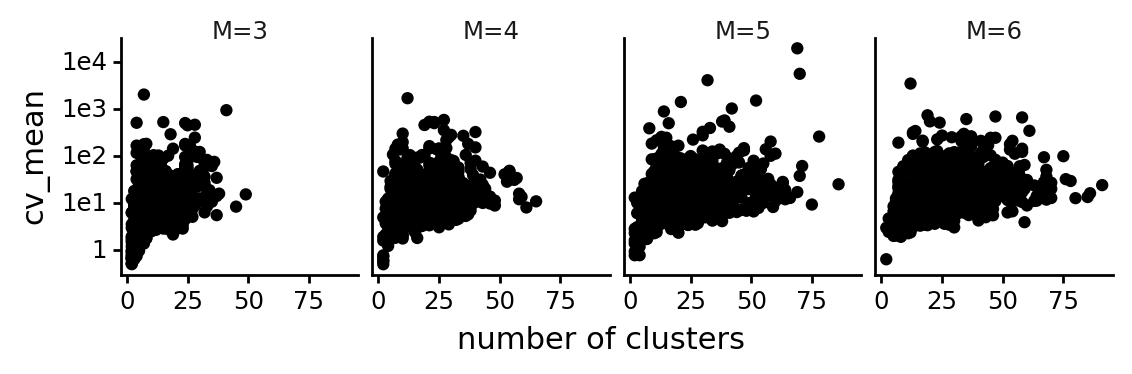

<ggplot: (8780603046126)>

In [335]:
(p9.ggplot(cluster_counts_df_long.query('n_clusters > 1'), p9.aes(x='n_clusters', y='cv_mean'))
 + p9.geom_point()
 + p9.theme_classic()
 + p9.facet_wrap('~network_size', nrow=1)
 + p9.xlab('number of clusters')
 + p9.scale_y_log10()
 + p9.theme(axis_text=p9.element_text(color='black'),
           aspect_ratio=1, strip_background=p9.element_blank()))
# p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_cluster_histogram_thresh5.pdf')


Can we generate a consensus set of functions across universes? Try clustering the basis functions from each universe. 

In [420]:
meta_link_all_thresh3 = [0]*4
meta_clust_all_thresh3 = [0]*4
for m in range(4):
    cluster_basis_combined = np.vstack(cluster_basis_all[m])
    
    meta_dist_combined, meta_link_combined, meta_clust_combined = \
    hc_mat(cluster_basis_combined.T, scale=False, threshold=3)
    
    #save data
    meta_link_all_thresh3[m] = meta_link_combined
    meta_clust_all_thresh3[m] = meta_clust_combined
    
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_dist_thresh3.npy'), meta_dist_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_linkage_thresh3.npy'), meta_link_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_clusters_thresh3.npy'), meta_clust_combined)

In [421]:
meta_link_all_thresh5 = [0]*4
meta_clust_all_thresh5 = [0]*4
for m in range(4):
    cluster_basis_combined = np.vstack(cluster_basis_all_5[m])
    
    meta_dist_combined, meta_link_combined, meta_clust_combined = \
    hc_mat(cluster_basis_combined.T, scale=False, threshold=3)
    
    #save data
    meta_link_all_thresh5[m] = meta_link_combined
    meta_clust_all_thresh5[m] = meta_clust_combined
    
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_dist_thresh5.npy'), meta_dist_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_linkage_thresh5.npy'), meta_link_combined)
    np.save(os.path.join(outdir, f'hc_{m+3}M_meta_clusters_thresh5.npy'), meta_clust_combined)

Plot random meta clusters

In [423]:

for m in range(4):
    clust_rand10 = np.random.choice(np.arange(meta_clust_all_thresh3[m].max()), 10, replace=False)
    
    cluster_basis_combined = np.vstack(cluster_basis_all[m])
    
    fig1, axes1 = plot_outcurves_clustered2(cluster_basis_combined.T, 
                                            meta_clust_all_thresh3[m],
                                            clusters=clust_rand10, shaded='max-min', xticks = [0,49,99],
                                            xticklabels = [-3,0,3], add_legend = True)
    fig1.savefig(f'../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_curves_{m+3}M_metaclusters_thresh3.pdf')
    plt.close()


Count the number of meta cluster across different network sizes

In [437]:
meta_clust_count_df = pd.DataFrame({'network_size': [f'm={i+3}' for i in range(4)], 
                                    'n_clusters':[i.max() for i in meta_clust_all_thresh3]})

In [440]:
p=(p9.ggplot(meta_clust_count_df, p9.aes(x='network_size', y='n_clusters'))
 +p9.geom_bar(stat='identity')
 +p9.theme_classic()
 +p9.ylab('number of meta clusters')
 +p9.xlab('network size')
 +p9.theme(axis_text=p9.element_text(color='black')))
p.save('../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_thresh3.pdf')


/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/benjaminemert/miniconda3/envs/py39/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../plots/20220617_1input_randomParams_highRes/hierarchical_clustering/hc_num_metaClusters_histogram_thresh3.pdf


Count how many meta clusters per parameter universe? And conversely, how many univeres per meta cluster?

In [427]:
univ_cluster_df_all = [0]*4
cluster_per_univ_df_all = [0]*4
univ_per_cluster_df_all = [0]*4
for m in range(4):
    univ_ncluster_array = np.repeat(cluster_counts_df['univ'], cluster_counts_df[f'M={m+3}'])
    univ_cluster_df = pd.DataFrame({'univ': univ_ncluster_array,
                                    'meta_clust': meta_clust_all_thresh3[m]})
    
    cluster_per_univ_df =  univ_cluster_df.groupby('univ')['meta_clust'].nunique()
    univ_per_cluster_df = univ_cluster_df.groupby('meta_clust')['univ'].nunique()
    
    univ_cluster_df_all[m] = univ_cluster_df
    cluster_per_univ_df_all[m] = cluster_per_univ_df
    univ_per_cluster_df_all[m] = univ_per_cluster_df


In [34]:
def plot_outcurves_clustered_all(outmat, cluster_labels, ncols = 20, ylim=(-0.05,1.05), 
                   xticks = [0,4,9], xticklabels = [-3,0,3], add_legend = False):
    """
    """
    clusters = np.unique(cluster_labels)
    n_clusters = len(clusters)
    # n_outweights = outmat.shape[2]
    n_titration = outmat.shape[0]
    nrows = math.ceil(n_clusters/ncols)
    xticklabels = [f'$10^{{{i}}}$' for i in xticklabels]
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5), squeeze=False, constrained_layout=True)
    axes_ind = list(itertools.product(np.arange(nrows), np.arange(ncols)))
    for i, clust in enumerate(clusters):
        cluster_ind = np.nonzero(cluster_labels == clust)[0]
        outmat_clust = outmat[:,cluster_ind]
        for j,curve in enumerate(cluster_ind):
            axes[axes_ind[i]].plot(np.arange(n_titration), outmat_clust[:,j], label=f'{curve}')
            axes[axes_ind[i]].set(ylabel='out',
                               xticks = xticks, xticklabels = xticklabels,
                               title=f'cluster: {clust}')
            if add_legend:
                axes[(0,i)].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='weight set')

    return fig, axes
        
    

In [35]:
_,_ = plot_outcurves_clustered_all(out_2_standard_flat, out_clusters, xticks=[0,49,99])

Try clustsering individual dimers, without apply output weights

In [172]:
S_all_3M = np.load('../../data/20220420_1input_randomParams/S_all_3M_1000k.npy')

In [173]:
S_all_3M.shape

(10, 9, 1000)

In [174]:
S_all_3M_mn = S_all_3M.mean(axis = 0)
S_all_3M_sd = S_all_3M.std(axis = 0)
S_all_3M_standard = (S_all_3M - S_all_3M_mn[np.newaxis,:,:])/S_all_3M_sd[np.newaxis,:,:]

In [142]:
make_Kij_names(n_input=1, n_accesory=2)

['K11', 'K12', 'K13', 'K22', 'K23', 'K33']

In [177]:
thresh = 1
global_clusters = hcluster.fclusterdata(S_all_3M_standard[:,7,:].T, thresh, 
                                        method = 'centroid', criterion = "distance", metric='euclidean')
global_sclusterind = np.argsort(global_clusters)

In [166]:
np.where(global_clusters == 9)

(array([873]),)

In [170]:
np.unique(global_clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44], dtype=int32)

In [164]:
S_all_3M_norm = S_all_3M/S_all_3M.max(axis = 0)[np.newaxis,:,:]

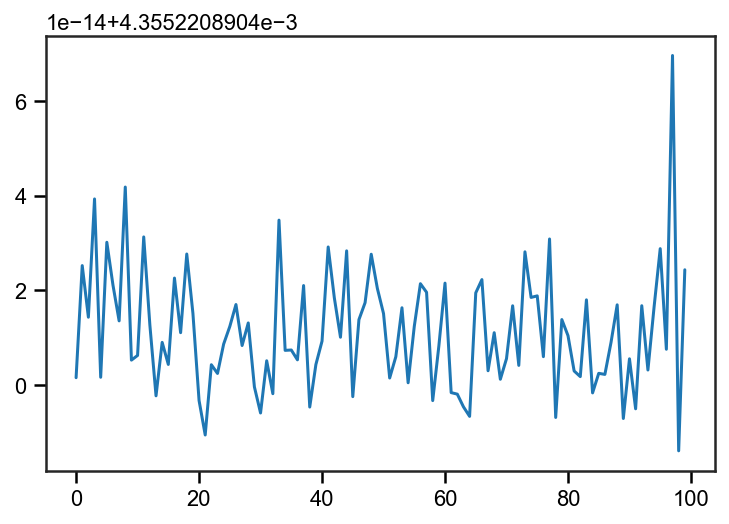

In [168]:
plt.plot(np.arange(100),S_all_3M[:,7,873])

In [158]:
S_all_3M_standard[:,7,329]

array([-0.56629343, -0.28524551, -0.2852438 , -0.28524184, -0.2852396 ,
       -0.28523701, -0.28523403, -0.2852306 , -0.28522667, -0.28522215,
       -0.28521696, -0.28521097, -0.28520409, -0.28519619, -0.28518709,
       -0.28517664, -0.28516462, -0.28515081, -0.28513491, -0.28511665,
       -0.28509564, -0.2850715 , -0.28504372, -0.28501179, -0.28497508,
       -0.28493285, -0.28488431, -0.28482849, -0.28476429, -0.28469045,
       -0.28460557, -0.28450793, -0.28439566, -0.28426652, -0.28411801,
       -0.28394716, -0.28375066, -0.28352461, -0.28326454, -0.28296533,
       -0.28262104, -0.28222482, -0.28176879, -0.28124383, -0.28063941,
       -0.27994339, -0.27914165, -0.27821793, -0.27715332, -0.27592587,
       -0.27451014, -0.27287646, -0.27099026, -0.26881119, -0.26629201,
       -0.26337731, -0.26000192, -0.25608899, -0.2515475 , -0.24626946,
       -0.24012605, -0.23296311, -0.22459519,  3.84382661,  3.41221223,
        3.1701094 ,  3.07272615,  2.96339191,  2.84117337,  2.70

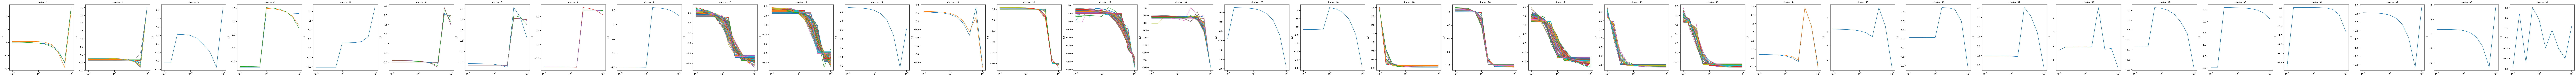

In [178]:
_, _  = plot_outcurves_clustered(S_all_3M_standard[:,7,:], global_clusters, xticks=[0,4,9])